In [1]:
import numpy as np

In [9]:
# success probabilities based on tool quality
p_0 = 0.8
p_1 = 0.6
p_2 = 0.2

# (action, k2-k1, l1, l2, m1, m2) : prob
probabilities = {
    # successful Y job
    ('Y',  2, 0, 1, 1, 1) : p_0,
    ('Y',  2, 1, 2, 1, 1) : p_1,
    ('Y',  2, 2, 2, 1, 1) : p_2,

    # failed Y job
    ('Y',  -1, 0, 0, 1, 0) : 1 - p_0,
    ('Y',  -1, 1, 0, 1, 0) : 1 - p_1,
    ('Y',  -1, 2, 0, 1, 0) : 1 - p_2,
}

for m in [0, 1]:
    probabilities.update({
        # successful A job
        ('A',  1, 0, 1, m, 0) : p_0,
        ('A',  1, 1, 2, m, 0) : p_1,
        ('A',  1, 2, 2, m, 0) : p_2,

        # failed A job
        ('A',  0, 0, 0, m, 0) : 1 - p_0,
        ('A',  0, 1, 0, m, 0) : 1 - p_1,
        ('A',  0, 2, 0, m, 0) : 1 - p_2,

        # preparation
        ('X',  0, 0, 0, m, 1) : 1,
        ('X',  0, 1, 0, m, 1) : 1,
        ('X',  0, 2, 1, m, 1) : 1,
    })


def p(a, k1, l1, m1, k2, l2, m2):
    key = (a, k2 - k1, l1, l2, m1, m2)
    if key in probabilities:
        return probabilities[key]
    else:
        return 0

def actions(k, m):
    if m == 1:
        return ['A','X','Y']
    else:
        return ['A','X']

In [10]:
V = np.zeros((5,7,3,2))
A = np.zeros((5,7,3,2), dtype='str')

In [11]:
K = [0,1,2,3,4,5,6]
L = [0,1,2]
M = [0,1]

I = [(k,l,m) for k in K for l in L for m in M]

In [12]:
len(I)

42

In [13]:
# initialize last timestep (zero decision epochs left)
for k in K:
    V[0,k,:,:] = k

# dynamic programming
for n in range(1,4+1):
    for k1,l1,m1 in I:
        maximum = 0
        argmax = ''
        for a in actions(k1,m1):
            S = sum(
                p(a, k1,l1,m1, k2,l2,m2) * V[n-1,k2,l2,m2]
                for k2,l2,m2 in I
            )
            if S > maximum:
                maximum = S
                argmax = a
            
        V[n,k1,l1,m1] = maximum
        A[n,k1,l1,m1] = argmax

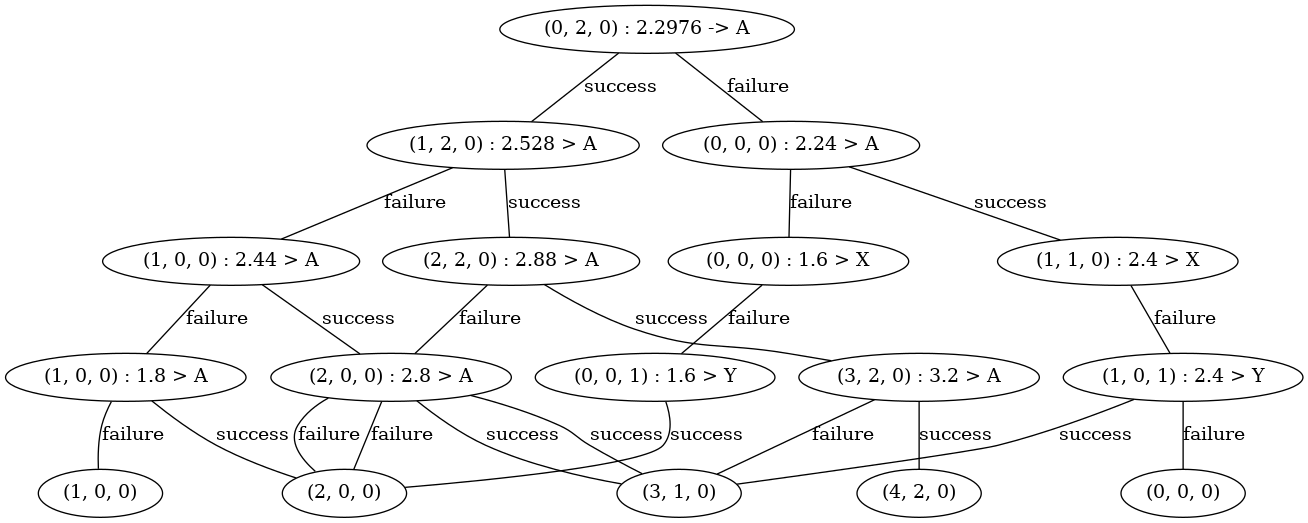

In [16]:
import pydot

graph = pydot.Dot("policy", graph_type="graph")

# list of lists containing possible states for each timestep
s = []

# initial state, value and next action
i0 = (0,2,0)
v0 = V[(4,*i0)]
a0 = A[(4,*i0)]
s.append([(i0, v0, a0)])
graph.add_node(pydot.Node(str((4, i0[0], a0)), label=f"{i0} : {v0:.5g} -> {a0}"))

# only consider states that have a positive probability of actually occuring
for n in range(3,-1,-1):
    states = set()
    # iterate over all states that were reachable in the previous timestep
    for i,_,a in s[-1]:
        for j in I:
            trans = p(a, *i, *j)
            if trans > 0: # only reachable states
                vn = V[(n,*j)] # current value
                an = A[(n,*j)] # optimal next action
                states.add((j, vn, an))

                state_label = (f"{j}" + (f" : {vn:.5g} > {an}" if an != '' else ''))
                graph.add_node(pydot.Node(str((n,j[0],an)), label=state_label))
                
                edge_label = 'success' if j[1] else 'failure'
                graph.add_edge(pydot.Edge(str((n+1,i[0],a)), str((n,j[0],an)), label=edge_label))
    
    s.append(states)

file_name = 'policy.png'
graph.write_png(file_name)
from IPython.display import Image
Image(filename=file_name)

In [8]:
s

[[((2, 0, 0), 4.873599999999999, 'A')],
 {((2, 0, 0), 4.208, 'A'), ((3, 1, 0), 5.039999999999999, 'X')},
 {((2, 0, 0), 3.4400000000000004, 'A'),
  ((3, 0, 1), 5.039999999999999, 'Y'),
  ((3, 1, 0), 4.4, 'X')},
 {((2, 0, 0), 2.8000000000000003, 'A'),
  ((3, 0, 1), 4.4, 'Y'),
  ((3, 1, 0), 3.6, 'A'),
  ((5, 1, 1), 5.6, 'A')},
 {((2, 0, 0), 2.0, ''),
  ((3, 0, 0), 3.0, ''),
  ((3, 1, 0), 3.0, ''),
  ((4, 2, 0), 4.0, ''),
  ((5, 0, 0), 5.0, ''),
  ((5, 1, 1), 5.0, ''),
  ((6, 2, 0), 6.0, '')}]